In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Add, Activation
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical # Needed for Label Smoothing

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [15]:
def calculate_features(data):
    """
    The "Clean 89" Feature Set.
    Simple, robust geometry calculated AFTER augmentation.
    """
    # 1. Center Wrist at (0,0)
    wrist = data[0]
    data = data - wrist
    
    # 2. Scale Normalization
    palm_size = np.linalg.norm(data[9]) + 1e-6
    data = data / palm_size 
    
    # --- FEATURE 1: Raw Coordinates (63) ---
    flat_coords = data.flatten()
    
    # --- FEATURE 2: Distances (13) ---
    tips = [4, 8, 12, 16, 20]
    distances = []
    for i in range(1, 5): distances.append(np.linalg.norm(data[tips[0]] - data[tips[i]])) 
    for i in range(5): distances.append(np.linalg.norm(data[tips[i]])) 
    for i in range(4): distances.append(np.linalg.norm(data[tips[i]] - data[tips[i+1]])) 
        
    # --- FEATURE 3: Finger Extension Ratios (5) ---
    knuckles = [2, 5, 9, 13, 17]
    finger_ratios = []
    for i in range(5):
        dist_tip = np.linalg.norm(data[tips[i]])
        dist_knuckle = np.linalg.norm(data[knuckles[i]]) + 1e-6
        finger_ratios.append(dist_tip / dist_knuckle)

    # --- FEATURE 4: Angles (4) ---
    finger_bases = [2, 5, 9, 13, 17]
    vectors = []
    for i in range(5):
        vectors.append(data[tips[i]] - data[finger_bases[i]])
    angles = []
    for i in range(4):
        v1 = vectors[i]
        v2 = vectors[i+1]
        cosine = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2) + 1e-6)
        angles.append(np.arccos(np.clip(cosine, -1.0, 1.0)))

    # --- FEATURE 5: Z-Depth (4) ---
    z_feats = []
    thumb_tip_z = data[4][2]
    for i in [8, 12, 16, 20]: 
        z_feats.append(thumb_tip_z - data[i][2])
        
    return np.concatenate([flat_coords, np.array(distances), np.array(finger_ratios), np.array(angles), np.array(z_feats)])

In [17]:
# --- CONFIGURATION ---
KEYPOINTS_DIR = "keypoints_dataset" 
TARGET_TRAIN_SAMPLES = 1000 # How many samples we want per class in TRAINING

def augment_landmarks(landmarks):
    """Applies augmentation to RAW coordinates."""
    aug_data = landmarks.copy()
    
    # 1. Random Rotation (±20 degrees)
    theta = np.radians(np.random.uniform(-20, 20))
    c, s = np.cos(theta), np.sin(theta)
    rotation_matrix = np.array([[c, -s, 0], [s,  c, 0], [0,  0, 1]])
    
    wrist = aug_data[0]
    aug_data = aug_data - wrist
    aug_data = np.dot(aug_data, rotation_matrix)
    aug_data = aug_data + wrist
    
    # 2. Random Scaling (±10%)
    scale = np.random.uniform(0.9, 1.1)
    aug_data = aug_data * scale
    
    # 3. Light Noise
    noise = np.random.normal(0, 0.01, aug_data.shape)
    aug_data = aug_data + noise
    return aug_data

print("1. Loading RAW dataset...")
raw_X = []
raw_y = []

if os.path.exists(KEYPOINTS_DIR):
    classes = sorted(os.listdir(KEYPOINTS_DIR))
    for label in classes:
        class_path = os.path.join(KEYPOINTS_DIR, label)
        if not os.path.isdir(class_path): continue
        
        # Load all raw files for this class
        files = [f for f in os.listdir(class_path) if f.endswith(".npy")]
        for file in files:
            try:
                data = np.load(os.path.join(class_path, file))
                if data.size == 63: data = data.reshape(21, 3)
                if data.shape == (21, 3): 
                    raw_X.append(data)
                    raw_y.append(label)
            except: pass
        print(f"  Loaded {label}: {len(files)} raw samples")

raw_X = np.array(raw_X)
raw_y = np.array(raw_y)

# --- CRITICAL STEP: SPLIT RAW DATA FIRST ---
# We split the real data now. The Test set will NEVER see augmentation.
print(f"\n2. Splitting Raw Data (Total: {len(raw_X)})...")
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
    raw_X, raw_y, test_size=0.2, random_state=42, stratify=raw_y
)

print(f"  Raw Training: {len(X_train_raw)} samples")
print(f"  Raw Testing:  {len(X_test_raw)} samples")

# --- AUGMENTATION & PROCESSING ---
def process_dataset(X_data, y_data, augment=False, target_per_class=None):
    processed_X = []
    processed_y = []
    
    unique_classes = np.unique(y_data)
    
    for label in unique_classes:
        # Get all samples for this class
        indices = np.where(y_data == label)[0]
        class_samples = X_data[indices]
        
        # Add original samples
        for s in class_samples:
            processed_X.append(calculate_features(s))
            processed_y.append(label)
            
        # Augment if requested (TRAIN only)
        if augment and target_per_class:
            current_count = len(class_samples)
            needed = target_per_class - current_count
            
            if needed > 0:
                # Randomly select samples to augment
                aug_indices = np.random.choice(len(class_samples), needed, replace=True)
                for idx in aug_indices:
                    aug_sample = augment_landmarks(class_samples[idx]) # Augment raw
                    processed_X.append(calculate_features(aug_sample)) # Then extract
                    processed_y.append(label)
                    
    return np.array(processed_X), np.array(processed_y)

print("\n3. Processing Datasets...")
# Augment TRAINING set only
X_train, y_train_labels = process_dataset(X_train_raw, y_train_raw, augment=True, target_per_class=TARGET_TRAIN_SAMPLES)

# Do NOT augment TESTING set (Real world evaluation)
X_test, y_test_labels = process_dataset(X_test_raw, y_test_raw, augment=False)

# Encode Labels
encoder = LabelEncoder()
# Fit on ALL labels to ensure we know all classes
encoder.fit(raw_y) 

y_train = to_categorical(encoder.transform(y_train_labels))
y_test = to_categorical(encoder.transform(y_test_labels))

print("-" * 30)
print(f"Final Training Shape: {X_train.shape} (Augmented)")
print(f"Final Test Shape:     {X_test.shape} (Pure Real Data)")

1. Loading RAW dataset...
  Loaded A: 489 raw samples
  Loaded B: 571 raw samples
  Loaded C: 301 raw samples
  Loaded D: 440 raw samples
  Loaded E: 584 raw samples
  Loaded F: 433 raw samples
  Loaded G: 486 raw samples
  Loaded H: 701 raw samples
  Loaded I: 770 raw samples
  Loaded K: 290 raw samples
  Loaded L: 143 raw samples
  Loaded M: 161 raw samples
  Loaded N: 203 raw samples
  Loaded O: 390 raw samples
  Loaded P: 652 raw samples
  Loaded Q: 415 raw samples
  Loaded R: 743 raw samples
  Loaded S: 431 raw samples
  Loaded T: 227 raw samples
  Loaded U: 838 raw samples
  Loaded V: 663 raw samples
  Loaded W: 430 raw samples
  Loaded X: 405 raw samples
  Loaded Y: 241 raw samples

2. Splitting Raw Data (Total: 11007)...
  Raw Training: 8805 samples
  Raw Testing:  2202 samples

3. Processing Datasets...
------------------------------
Final Training Shape: (24000, 89) (Augmented)
Final Test Shape:     (2202, 89) (Pure Real Data)


In [18]:
def build_robust_resnet_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    
    # Standard L2
    reg = l2(0.0005)

    # --- Entry Block ---
    x = Dense(256, activation='relu', kernel_regularizer=reg)(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x) 

    # --- Residual Block 1 ---
    shortcut = x
    x = Dense(256, activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x) 
    x = Dense(256, kernel_regularizer=reg)(x) 
    x = BatchNormalization()(x)
    x = Add()([x, shortcut]) 
    x = Activation('relu')(x)

    # --- Residual Block 2 ---
    shortcut = x
    x = Dense(256, activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x) 
    x = Dense(256, kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = Add()([x, shortcut]) 
    x = Activation('relu')(x)

    # --- Output Head ---
    x = Dense(128, activation='relu', kernel_regularizer=reg)(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x) 
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs, name="Clean_89_ResNet")
    return model

# Build
input_shape = (X_train.shape[1],) 
num_classes = y_train.shape[1] 

model = build_robust_resnet_model(input_shape, num_classes)
model.summary()

Model: "Clean_89_ResNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 89)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 256)       │     23,040 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_14[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 256)       │     65,792 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_15[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 256)       │     65,792 │ dropout_9[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_16[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 256)       │          0 │ batch_normalizat… │
│                     │                   │            │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 256)       │          0 │ add_4[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, 256)       │     65,792 │ activation_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_17[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 256)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, 256)       │     65,792 │ dropout_10[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_18[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 256)       │          0 │ batch_normalizat… │
│                     │                   │            │ activation_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 256)       │          0 │ add_5[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, 128)       │     32,896 │ activation_5[0][… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 327,832 (1.25 MB)

 Trainable params: 325,016 (1.24 MB)

 Non-trainable params: 2,816 (11.00 KB)

In [19]:
loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1)
optimizer = Adam(learning_rate=0.001)

model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=8, min_lr=1e-6)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=1000,
    batch_size=64,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/1000


375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5003 - loss: 2.8189 - val_accuracy: 0.6694 - val_loss: 2.2057 - learning_rate: 0.0010
Epoch 2/1000
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6235 - loss: 2.3246 - val_accuracy: 0.7025 - val_loss: 2.0303 - learning_rate: 0.0010
Epoch 3/1000
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6600 - loss: 2.1374 - val_accuracy: 0.7289 - val_loss: 1.8956 - learning_rate: 0.0010
Epoch 4/1000
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6797 - loss: 2.0114 - val_accuracy: 0.7148 - val_loss: 1.8415 - learning_rate: 0.0010
Epoch 5/1000
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6910 - loss: 1.9172 - val_accuracy: 0.7421 - val_loss: 1.7517 - learning_rate: 0.0010
Epoch 6/1000
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7032 - loss: 1.8388 - val_accuracy: 0.7361 - val_loss: 1.7254 - learning_rate: 0.0010
Epoch 7/1000
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7076 - loss: 1.7821 -

Generating predictions...
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Test Loss: 1.0624
Test Accuracy: 91.14%


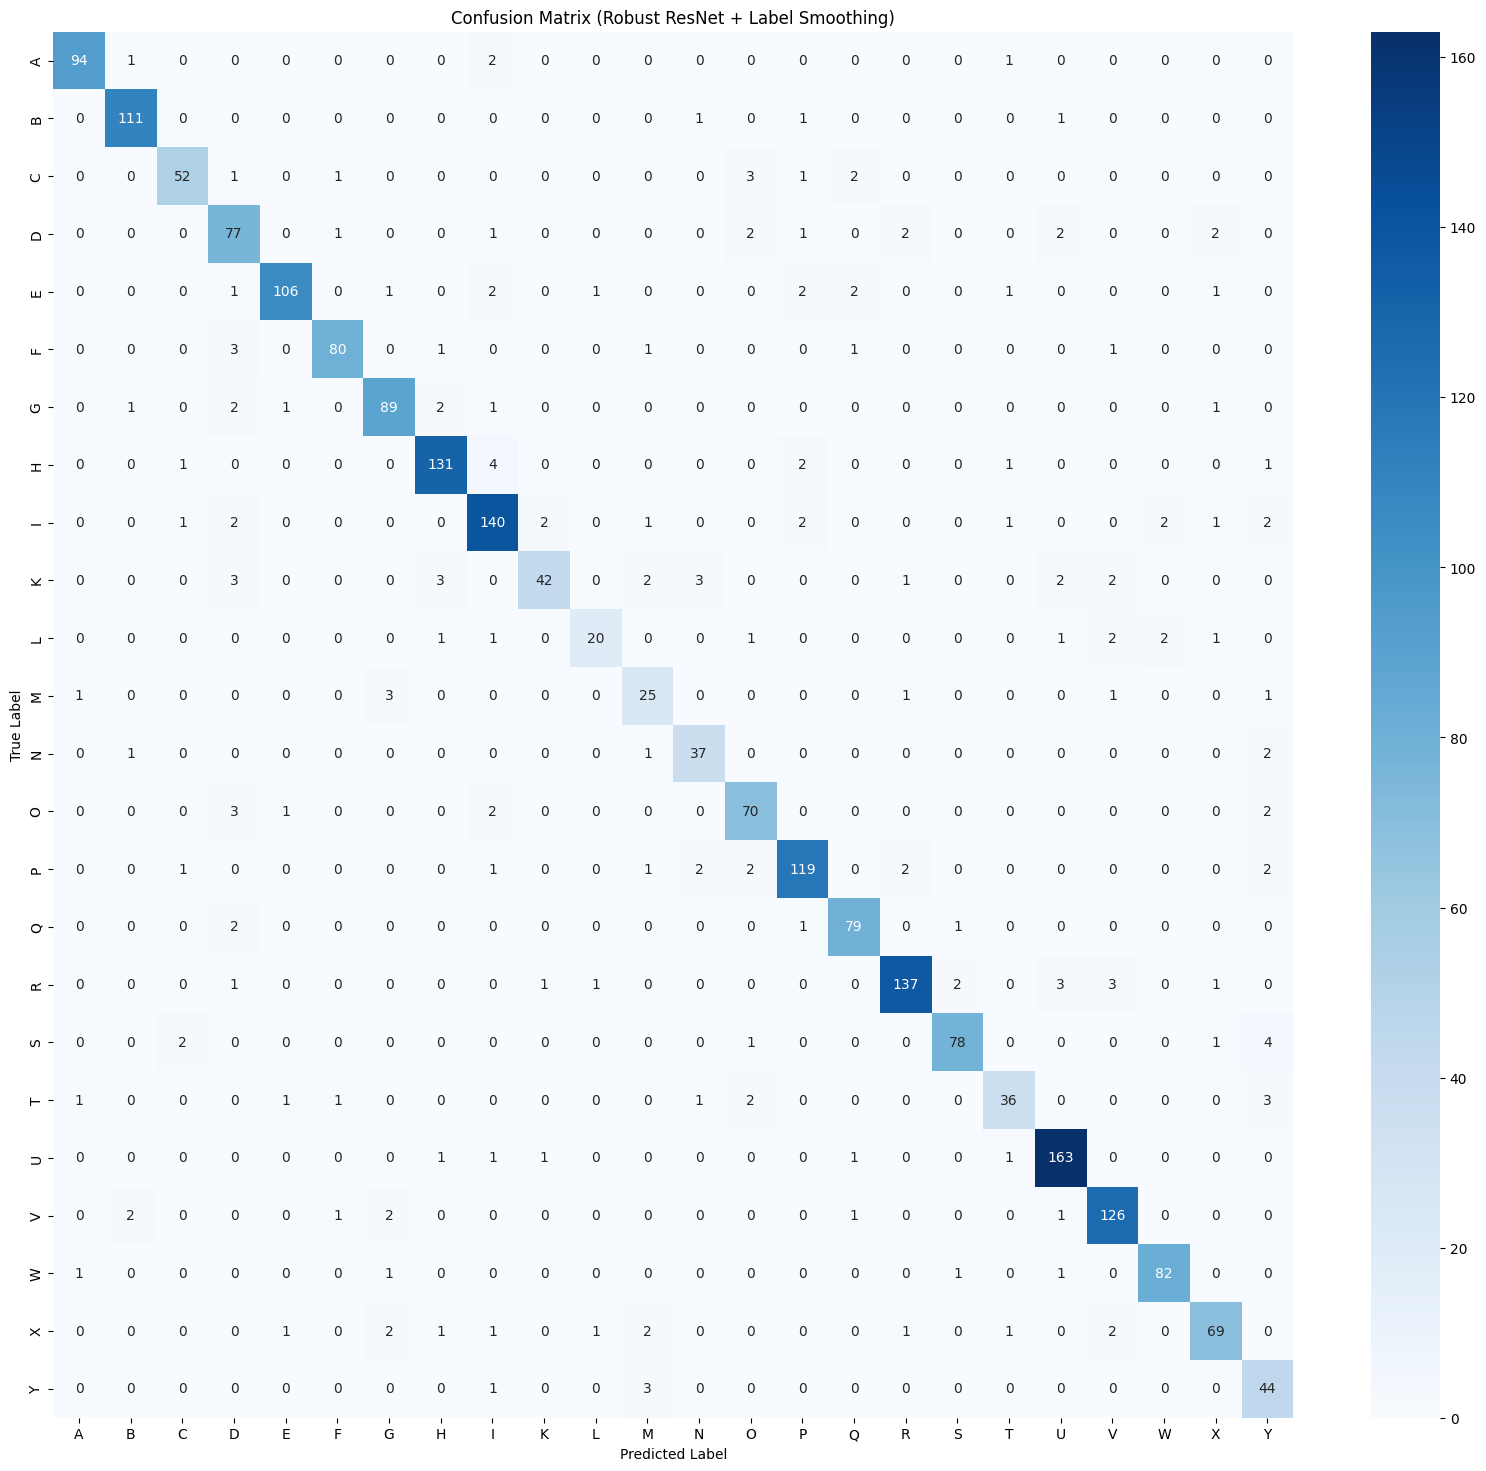


--- Classification Report ---
              precision    recall  f1-score   support

           A       0.97      0.96      0.96        98
           B       0.96      0.97      0.97       114
           C       0.91      0.87      0.89        60
           D       0.81      0.88      0.84        88
           E       0.96      0.91      0.93       117
           F       0.95      0.92      0.94        87
           G       0.91      0.92      0.91        97
           H       0.94      0.94      0.94       140
           I       0.89      0.91      0.90       154
           K       0.91      0.72      0.81        58
           L       0.87      0.69      0.77        29
           M       0.69      0.78      0.74        32
           N       0.84      0.90      0.87        41
           O       0.86      0.90      0.88        78
           P       0.92      0.92      0.92       130
           Q       0.92      0.95      0.93        83
           R       0.95      0.92      0.94       

In [20]:
# --- 1. Calculate Predictions ---
print("Generating predictions...")
y_pred = model.predict(X_test)

# Convert probabilities to class labels (0, 1, 2...)
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert ONE-HOT 'y_test' back to class labels (0, 1, 2...)
# This step is required because we used Label Smoothing!
y_true = np.argmax(y_test, axis=1)

# --- 2. Accuracy Check ---
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy*100:.2f}%")

# --- 3. Confusion Matrix ---
plt.figure(figsize=(20, 18))
cm = confusion_matrix(y_true, y_pred_classes) # Use y_true, not y_test

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=encoder.classes_, 
            yticklabels=encoder.classes_)
plt.title('Confusion Matrix (Robust ResNet + Label Smoothing)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# --- 4. Detailed Report ---
print("\n--- Classification Report ---")
print(classification_report(y_true, y_pred_classes, target_names=encoder.classes_))

# --- 5. Save the Model ---
# Save the model and the label encoder so you can use them in your app
model.save("asl_alphabet_model.keras")
np.save("encoder_classes.npy", encoder.classes_)
print("\nModel saved as 'asl_alphabet_model.keras'")
print("Encoder classes saved as 'encoder_classes.npy'")

In [21]:
model.save("asl_alphabet_model.h5")
model.save("asl_alphabet_model.keras")
print("Model saved successfully as 'asl_alphabet_model.h5'")
print("Model saved successfully as 'asl_alphabet_model.keras'")
np.save("encoder_classes.npy", encoder.classes_)

Model saved successfully as 'asl_alphabet_model.h5'
Model saved successfully as 'asl_alphabet_model.keras'
